# Capstone Project John Lawrence 02/2024

# Background

This project concerns the degree to which corporations in Peru comply with a set of 88 rules comprising a voluntary governance code introduced in 2014. 
The IVs are features of corporations thought to be drivers of compliance, developed in 2017. The DV(s) are the compliance of every corporation with a selection of 24 constitutive rules where there is most contestation and therefore where compliance is significantly lower than for the other c64 rules.
The purpose of this exercise is to see if machine learning provides the capacity to predict compliance outcomes based just on features of corporations engagement with financial, partner, and client markets..

Part A - I load and prepare the data for outcomes (y) and features (X)

Part B -  I carry out exploratory modelling with an group of six classifier models from scilearn

Part C - I tune 3 models, logistic, decision tree and random forest,  that track features and compare metrics before and after tuning 

Part D - I optimize the classification threshold for the logistic classifier trading off sensitivity and specificity as used in C above

Part E - I use lasoo regression to reduce the features list from 10 to 6  as used in C above



In [723]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter("ignore")

# A Load and prepare combined IV and DV data 

In [453]:
data = pd.read_excel('/Users/johnlawrence/Desktop/gov_wd/gov_proj.xlsx', sheet_name='iv_dv')


In [454]:
np.shape(data)

(204, 35)

In [455]:
# establish mean compliance by rule for later
mean_comp = data.iloc[:, 11:36].sum()/204
#mean_comp

In [456]:
#split out random train and test and check sum
train, test = train_test_split(data, test_size=0.3) 
train.shape[0] + test.shape[0] == data.shape[0] 


True

In [457]:
#separate features for X and outcome
# Full list of features
#X_train = train[["regulator", "sector", "blocksh", "ret_voters","loc_equity","loc_bonds", "int_fin", "bus_model", "multi_list", "family"]]

# Retain few features following lasso, and logistic and decision tree results
X_train = train[[ "sector", "blocksh", "ret_voters","int_fin",  "multi_list", "family"]]


X_train

,sector,blocksh,ret_voters,int_fin,multi_list,family
170,1,0,0,0,0,0
8,0,0,1,0,1,1
6,0,1,1,0,0,0
160,0,1,0,1,1,1
201,1,1,0,0,1,0
...,...,...,...,...,...,...
178,1,1,0,0,0,0
164,0,1,1,0,0,0
45,0,1,0,0,1,1
95,1,1,0,0,0,0


In [458]:
# ...and outcomes for y - here solus for trian
y_train = train["Q41"]
#y_train

In [459]:
y_train_2 = train[["Q6", "Q7", "Q11", "Q12","Q13","Q14","Q16", "Q17", "Q19","Q21","Q31","Q40","Q41","Q42","Q43","Q46","Q47","Q50","Q52","Q78","Q84","Q85","Q87","Q88"]]
#y_train_2
#Q12	Q13	Q14	Q16	Q17	Q19	Q21	Q31	Q40	Q41	Q42	Q43	Q46	Q47	Q50	Q52	Q78	Q84	Q85	Q87	Q88

In [460]:
#X_test = test[["regulator","sector",  "blocksh", "ret_voters","loc_equity","loc_bonds", "int_fin", "bus_model", "multi_list", "family"]]

# Retain few features following lasso, and logistic and decision tree results
X_test = test[[ "sector", "blocksh", "ret_voters","int_fin",  "multi_list", "family"]]

#X_test #"sector",

In [461]:
y_test = test["Q41"]
#y_test

In [462]:
y_test_2 = test[["Q6", "Q7", "Q11", "Q12","Q13","Q14","Q16", "Q17", "Q19","Q21","Q31","Q40","Q41","Q42","Q43","Q46","Q47","Q50","Q52","Q78","Q84","Q85","Q87","Q88"]]
#y_test_2

In [464]:
# Set a universal threshold for classification
threshold = 0.5

# B Ensemble modelling
Here I run six machine Learning approaches to see how they compare first on one rule, then on the whole gamut

In [465]:
# Set up multiple models in a dictionary

models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [466]:
models

{'Logistic Regression': LogisticRegression(),
 'Support Vector Machines': LinearSVC(),
 'Decision Trees': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(),
 'Naive Bayes': GaussianNB(),
 'K-Nearest Neighbor': KNeighborsClassifier()}

In [467]:
#threshold = 0.37
#predictions = model.predict(X_test)
#predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

In [468]:
#run the full model set and metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall, typeii, typei = {}, {}, {}, {}, {}
threshold = 0.3
for key in models.keys():
    
    # 1 Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # 2 Prediction  on test set
    predictions = (models[key].predict(X_test) >= threshold).astype(bool)
    
    # 3 Calculate Accuracy, Precision and Recall Metrics for y pred cf y test
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    typeii[key] = fn / (fn + tp)
    typei[key] = fp / (fp + tn)

In [469]:
# Tabulate results

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall','TypeII', 'TypeI'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['TypeII'] = typeii.values()
df_model['TypeI'] = typei.values()
print( "Metrics for rule 41" )
df_model

Metrics for rule 41


,Accuracy,Precision,Recall,TypeII,TypeI
Logistic Regression,0.629032,0.53125,0.680000,0.46875,0.266667
Support Vector Machines,0.629032,0.53125,0.680000,0.46875,0.266667
Decision Trees,0.693548,0.62500,0.740741,0.37500,0.233333
Random Forest,0.645161,0.62500,0.666667,0.37500,0.333333
Naive Bayes,0.709677,0.71875,0.718750,0.28125,0.300000
K-Nearest Neighbor,0.612903,0.28125,0.900000,0.71875,0.033333


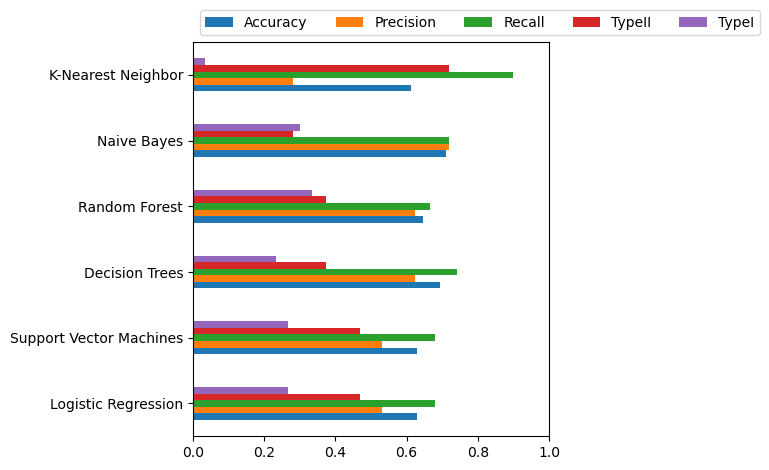

In [470]:
# Graph - horizontal bar plot of metrics for rule 41

ax  = df_model.plot.barh()
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.xlim(0.0, 1.0)
plt.tight_layout()

## Multiple models, multiple rules

In [531]:
# run all rules through the 6 models
#set a results folder
results = np.zeros((6,24))  # Initialize a 3x6 matrix to store accuracy scores

for i in range (24):
    #print("Accuracy for Rule: ", i+1)
    
    for j, key in enumerate (models.keys()):
        models[key].fit(X_train, y_train_2.iloc[:,i])
        #predictions = models[key].predict(X_test)
        predictions =(models[key].predict(X_test) >= threshold).astype(bool)
        TN, FP, FN, TP = confusion_matrix(y_test_2.iloc[:,i], predictions).ravel()
        accuracy =  (TP+TN) /(TP+FP+TN+FN)
        precision = TP / (TP + FP) 
        sensitivity = TP / (TP + FN) 
        specificity = TN / (TN + FP)
        #print("model name", models[key],  round(accuracy, 2))
        results[j,i] = sensitivity
#results    
        
   

In [203]:
row_sums = np.sum(results, axis=1)
model_means = row_sums/24
model_means

array([0.36640958, 0.38549281, 0.35385954, 0.40823043, 0.35629141,
       0.3024319 ])

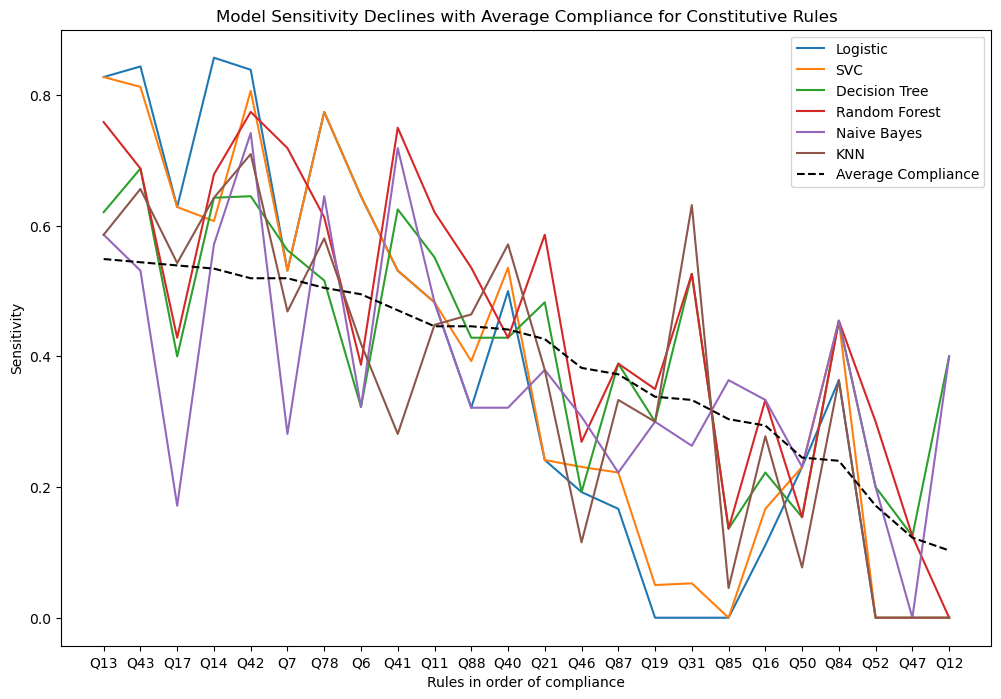

In [473]:
# see if correlated with compliance
sorted_indices = np.argsort(mean_comp)[::-1]
plt.figure(figsize=(12, 8))
plt.plot( results[0,sorted_indices], label='Logistic')
plt.plot( results[1,sorted_indices], label='SVC')
plt.plot( results[2,sorted_indices], label='Decision Tree')
plt.plot( results[3,sorted_indices], label='Random Forest')
plt.plot( results[4,sorted_indices], label='Naive Bayes')
plt.plot( results[5,sorted_indices], label='KNN')
plt.plot( mean_comp[sorted_indices], label='Average Compliance', linestyle='--', color='black')
plt.xlabel('Rules in order of compliance')
plt.ylabel('Sensitivity')
plt.title('Model Sensitivity Declines with Average Compliance for Constitutive Rules')
plt.legend()
plt.show()


# C Tuning of  3  models to improve results

## Macro parameters

In [532]:

# Set a universal threshold for classification
threshold = 0.39

# Set up a receptacle for each model individually
results_com = np.zeros((3,10))

## 1. Logistic model

In [654]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')# liblinear

model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [655]:
# Basic model prediction

predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

# run metrics
cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) 
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
results_com[0,0] = accuracy
results_com[0,1] = sensitivity
results_com[0,2] = precision
results_com[0,3] = specificity
results_com[0,4] = misclassification_rate
cm


array([[17, 13],
       [ 5, 27]])

In [656]:
print("Logistic Results:",
      "\nAccuracy:    ", round(accuracy,3),
      "\nSensitivity: ", round(sensitivity,3),
      "\nPrecision:   ", round(precision,3),  
      "\nSpecificity: ", round(specificity,3)) 

Logistic Results: 
Accuracy:     0.71 
Sensitivity:  0.844 
Precision:    0.675 
Specificity:  0.567


In [657]:
# Search for an improved model
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 50)
}

# Create the grid search model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit the grid search model to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 0.2682695795279725, 'penalty': 'l2'}


In [658]:
# Run tuned model
penalty = 'l2'  # or 'l1'
C = 0.2682695795279725  # Regularization parameter

model_imp = LogisticRegression(solver='liblinear', penalty = penalty, C = C)
model_imp.fit(X_train, y_train)
#predictions = model.predict(X_test)
predictions = (model_imp.predict_proba(X_test)[:,1] >= threshold).astype(bool)

In [659]:
cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = (cm[1][1]) / (cm[1][1] + cm[0][1])
sensitivity = (cm[1][1]) / (cm[1][1] + cm[1][0]) 
specificity = (cm[0][0]) / (cm[0][0] + cm[0][1])
results_com[0,5] = accuracy
results_com[0,6] = sensitivity
results_com[0,7] = precision
results_com[0,8] = specificity
results_com[0,9] = misclassification_rate
cm

array([[13, 17],
       [ 5, 27]])

Feature ranking based on logistic coefficients:
sector: 0.7
int_fin: 0.496
ret_voters: 0.484
multi_list: -0.283
blocksh: -0.471
family: -0.728


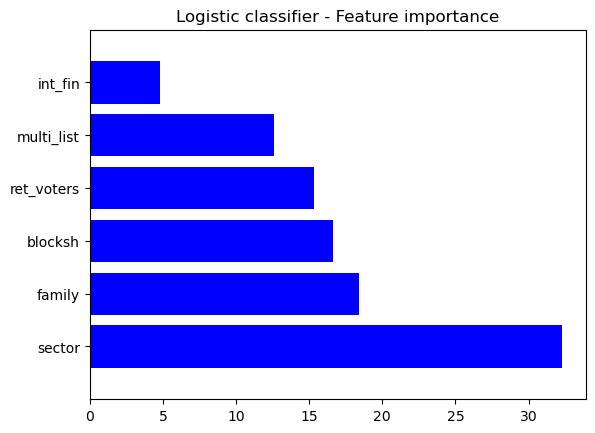

In [666]:
# Identify feature importance

# Obtain the coefficients of the regression?
coefficients = model.coef_
feature_names = X_train.columns

# Match the coefficients to feature names

coef_dict = {}
for coef, feat in zip(model_imp.coef_[0], feature_names):
    coef_dict[feat] = round(coef, 3)

# Sort the coefficients and feature names
sorted_coef = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1],reverse=True)}

# Print the feature ranking based on the coefficients
print("Feature ranking based on logistic coefficients:")
for feat, coef in sorted_coef.items():
    print(f"{feat}: {coef}")
    
    # Plot the importance 

plt.figure()
plt.title("Logistic classifier - Feature importance")
plt.barh(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])  # Use feature_names for y-axis labels
plt.ylim([-1, X_train.shape[1]])
plt.show()

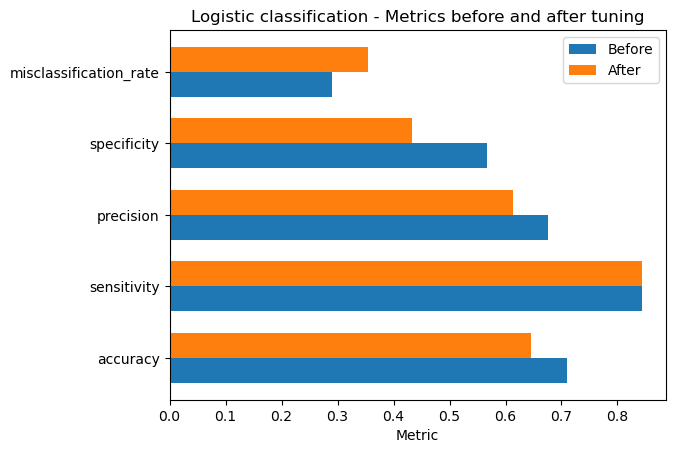

In [634]:
# Identify the impact of tuning

model1_before = results_com[0, :5]
model1_after = results_com[0, 5:]

# Create a horizontal bar chart
fig, ax = plt.subplots()
metrics = ['accuracy', 'sensitivity', 'precision', 'specificity', 'misclassification_rate']
bar_width = 0.35
index = np.arange(len(metrics))
before_bars = ax.barh(index, model1_before, bar_width, label='Before')
after_bars = ax.barh(index + bar_width, model1_after, bar_width, label='After')

ax.set_xlabel('Metric')
ax.set_title('Logistic classification - Metrics before and after tuning')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(metrics)
ax.legend()

plt.show()

## 2. Simple Decision Trees

In [635]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()

In [636]:
# Basic model
model.fit(X_train, y_train)

#predictions = model.predict(X_test)
predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) 
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
results_com[1,0] = accuracy
results_com[1,1] = sensitivity
results_com[1,2] = precision
results_com[1,3] = specificity
results_com[1,4] = misclassification_rate
cm

array([[18, 12],
       [ 6, 26]])

In [637]:
print("DT Results:",
      "\nAccuracy:    ", round(accuracy,3),
      "\nSensitivity: ", round(sensitivity,3),
      "\nPrecision:   ", round(precision,3),  
      "\nSpecificity: ", round(specificity,3)) 

DT Results: 
Accuracy:     0.71 
Sensitivity:  0.812 
Precision:    0.684 
Specificity:  0.6


In [638]:
# # Search for an improved model

# Use a parameter grid to define the oprinal parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10),
    'min_samples_split': [2, 5, 10]
}

# Create a DecisionTreeClassifier
model = DecisionTreeClassifier()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Produce the best hyperparameters
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [639]:
# tuned model to refit and repredict

model_imp = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
model_imp.fit(X_train, y_train)

predictions = model_imp.predict(X_test)
cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) 
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
results_com[1,5] = accuracy
results_com[1,6] = sensitivity
results_com[1,7] = precision
results_com[1,8] = specificity
results_com[1,9] = misclassification_rate
cm

array([[23,  7],
       [10, 22]])

In [640]:
print("DT Results:",
      "\nAccuracy:    ", round(accuracy,3),
      "\nSensitivity: ", round(sensitivity,3),
      "\nPrecision:   ", round(precision,3),  
      "\nSpecificity: ", round(specificity,3)) 

DT Results: 
Accuracy:     0.726 
Sensitivity:  0.688 
Precision:    0.759 
Specificity:  0.767


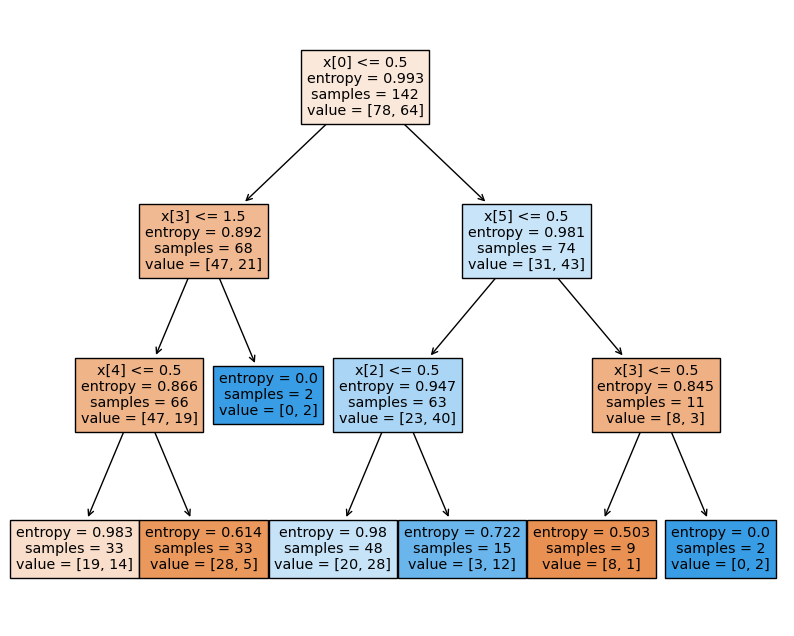

In [641]:
#visualize the improved decision tree
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
tree.plot_tree(model_imp, filled=True)
plt.show()

Feature rankings from DT with percentages:
1. Feature: int_fin (31.9)
2. Feature: sector (30.0)
3. Feature: multi_list (17.2)
4. Feature: family (14.1)
5. Feature: ret_voters (6.9)
6. Feature: blocksh (0.0)


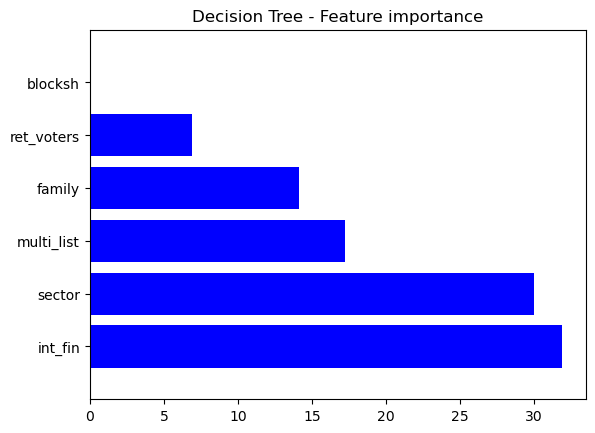

In [642]:
# Identify the important features driving the tree 

importances = model_imp.feature_importances_
importances = np.round(importances*100,1)

# Pick up the feature names fro m the column headings of X_train
feature_names = X_train.columns  # Get the column names as feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature rankings from DT with percentages:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature: {feature_names[indices[f]]} ({importances[indices[f]]})") 
    
# Plot the importance 

plt.figure()
plt.title("Decision Tree - Feature importance")
plt.barh(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])  # Use feature_names for y-axis labels
plt.ylim([-1, X_train.shape[1]])
plt.show()

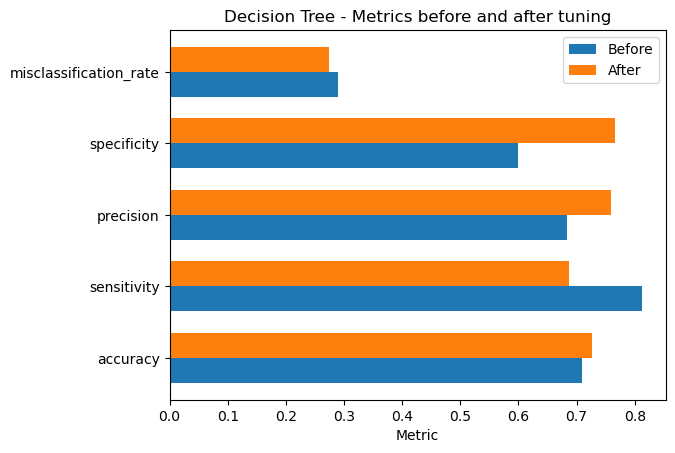

In [643]:
# Identify the impact of tuning

model2_before = results_com[1, :5]
model2_after = results_com[1, 5:]

# Calculate the difference
#difference = model1_after - model1_before

# Create a horizontal bar chart
fig, ax = plt.subplots()
metrics = ['accuracy', 'sensitivity', 'precision', 'specificity', 'misclassification_rate']
bar_width = 0.35
index = np.arange(len(metrics))
before_bars = ax.barh(index, model2_before, bar_width, label='Before')
after_bars = ax.barh(index + bar_width, model2_after, bar_width, label='After')

ax.set_xlabel('Metric')
ax.set_title('Decision Tree - Metrics before and after tuning')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(metrics)
ax.legend()

plt.show()

# 3. Random Forest

In [668]:
# Basic Model
model = RandomForestClassifier()
model.fit(X_train, y_train)

#predictions = model.predict(X_test)
predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) 
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
results_com[2,0] = accuracy
results_com[2,1] = sensitivity
results_com[2,2] = precision
results_com[2,3] = specificity
results_com[2,4] = misclassification_rate
cm

array([[19, 11],
       [ 8, 24]])

In [670]:
print("RF Results:",
      "\nAccuracy:    ", round(accuracy,3),
      "\nSensitivity: ", round(sensitivity,3),
      "\nPrecision:   ", round(precision,3),  
      "\nSpecificity: ", round(specificity,3)) 


RF Results: 
Accuracy:     0.694 
Sensitivity:  0.75 
Precision:    0.686 
Specificity:  0.633


In [671]:
# Search for an improved model

# Create the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# Fit the GridSearchCV object to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [672]:
# Set up the improved model
model_imp = RandomForestClassifier(max_depth = 10,
 max_features= 'sqrt',
 min_samples_leaf= 4,
 min_samples_split= 10,
 n_estimators = 100)

# Run the improved model

model_imp.fit(X_train, y_train)

#predictions = model_imp.predict(X_test)
predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
accuracy = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
misclassification_rate = (cm[0][1] + cm[1][0])/np.sum(cm)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0]) 
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
results_com[2,5] = accuracy
results_com[2,6] = sensitivity
results_com[2,7] = precision
results_com[2,8] = specificity
results_com[2,9] = misclassification_rate
cm

array([[19, 11],
       [ 8, 24]])

In [673]:
print("RF Results:",
      "\nAccuracy:    ", round(accuracy,3),
      "\nSensitivity: ", round(sensitivity,3),
      "\nPrecision:   ", round(precision,3),  
      "\nSpecificity: ", round(specificity,3)) 

RF Results: 
Accuracy:     0.694 
Sensitivity:  0.75 
Precision:    0.686 
Specificity:  0.633


Random Forest - Feature rankings and percentages:
1. Feature: sector (32.2)
2. Feature: ret_voters (17.7)
3. Feature: family (17.2)
4. Feature: blocksh (16.3)
5. Feature: multi_list (11.9)
6. Feature: int_fin (4.7)


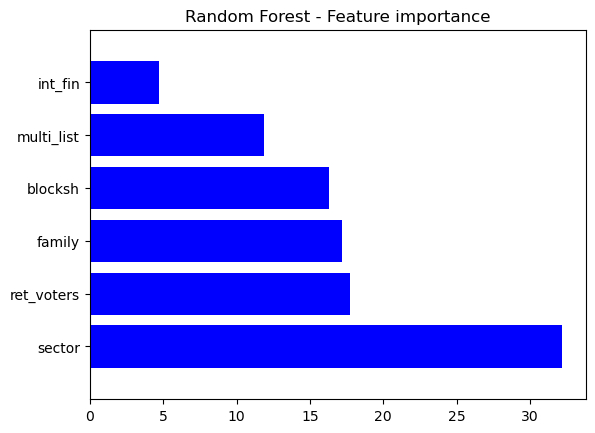

In [674]:
# Identify the important features driving the tree 
importances = model_imp.feature_importances_
importances = np.round(importances*100,1)

# Pick up the feature names fro m the column headings of X_train
feature_names = X_train.columns  # Get the column names as feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Random Forest - Feature rankings and percentages:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature: {feature_names[indices[f]]} ({importances[indices[f]]})") 
    
# Plot the importance 
plt.figure()
plt.title("Random Forest - Feature importance")
plt.barh(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])  # Use feature_names for y-axis labels
plt.ylim([-1, X_train.shape[1]])
plt.show()

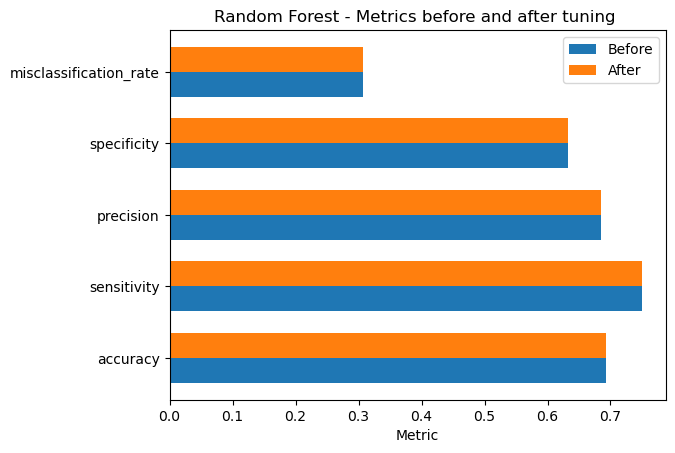

In [679]:
# Identify the impact of tuning

model3_before = results_com[2, :5]
model3_after = results_com[2, 5:]

# Calculate the difference
#difference = model1_after - model1_before

# Create a horizontal bar chart
fig, ax = plt.subplots()
metrics = ['accuracy', 'sensitivity', 'precision', 'specificity', 'misclassification_rate']
bar_width = 0.35
index = np.arange(len(metrics))
before_bars = ax.barh(index, model3_before, bar_width, label='Before')
after_bars = ax.barh(index + bar_width, model3_after, bar_width, label='After')

ax.set_xlabel('Metric')
ax.set_title('Random Forest - Metrics before and after tuning ')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(metrics)
ax.legend()

plt.show()

# D Optimizing the classifier threshold

In [680]:
# Using the preferred logistic model
model = LogisticRegression(solver='liblinear')# liblinear
model.fit(X_train, y_train)


In [716]:
results_opt = np.zeros(20)
sensitivity = np.zeros(20)
specificity = np.zeros(20)

for i in range(30,50,1):
    
    threshold = (i)/100
    predictions = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

    cm = confusion_matrix(y_test, predictions) # note effect of no .ravel()
    sensitivity[i-30] = cm[1][1] / (cm[1][1] + cm[1][0]) 
    specificity[i-30] = cm[0][0] / (cm[0][0] + cm[0][1])
    results_opt[i-30] = sensitivity[i-30] + specificity[i-30]
  
    #print(round(specificity[i-30],3))
index =np.argmax(results_opt)
print("The optimal threshold is:", 0.3+index/100)


The optimal threshold is: 0.39


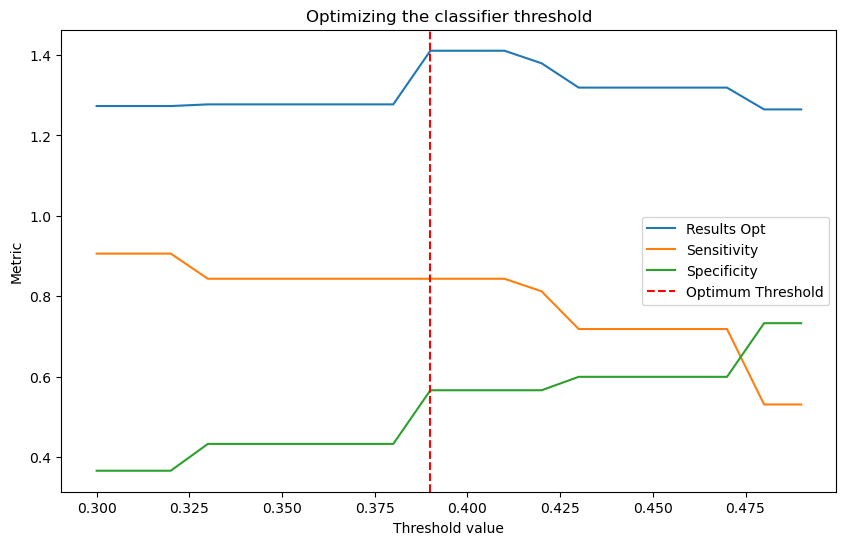

In [727]:
# Showing this graphically

x = np.arange(0.3, 0.50, 0.01)  # Create an array for the x-axis

# Plot the line graphs
plt.figure(figsize=(10, 6))
plt.plot(x, results_opt, label='Results Opt')
plt.plot(x, sensitivity, label='Sensitivity')
plt.plot(x, specificity, label='Specificity')
plt.axvline(x=0.39, color='r', linestyle='--', label='Optimum Threshold') 

# Add labels and title
plt.xlabel('Threshold value')
plt.ylabel('Metric')
plt.title('Optimizing the classifier threshold')
plt.legend()  
plt.show()

# E Testing for significance

In [718]:
# Set up a simulation of 1000 runs of the logistic model with a fresh train & test 
threshold = 0.39

results = np.zeros((5,1000))
for i in range(1000):
    train, test = train_test_split(data, test_size=0.3) 
    X_train = train[[ "sector", "blocksh", "ret_voters", "int_fin", "bus_model", "multi_list", "family"]]
    y_train = train["Q41"]
    X_test = test[["sector",  "blocksh", "ret_voters", "int_fin", "bus_model", "multi_list", "family"]]
    y_test = test["Q41"]

    model = LogisticRegression(solver='newton-cg')
    model.fit(X_train, y_train)
    #predictions = model.predict(X_test)
    predictions =(model.predict(X_test) >= threshold).astype(bool)
    
    cm = confusion_matrix(y_test, predictions)
    results[0,i] = cm[0][0]
    results[1,i] = cm[1][1]
    results[2,i] = cm[0][1]
    results[3,i] = cm[1][0]
    results[4,i] = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
    


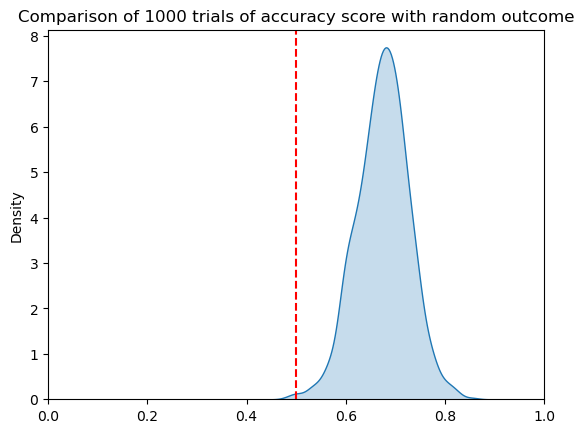

Mean and SD of Accuracy scores:   0.6741 +/- 0.0528
Probability that the distribution is below x = 0.5 is  0.0005


In [724]:
# Show that results are significantly better than random
# Extract the 5th row of the "results" array - accuracy
values = results[4, :]
mean = np.mean(values)
std_dev = np.std(values)

# Create a smooth distribution plot
sns.kdeplot(values, fill=True)
plt.axvline(x=0.5, color='r', linestyle='--')  # Add a vertical line at x = 0.5
plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
plt.title("Comparison of 1000 trials of accuracy score with random outcome")
plt.show()

print("Mean and SD of Accuracy scores:  ", round(mean,4),"+/-", round(std_dev,4))
prob_below_0_5 =  norm.cdf(0.5, loc=mean, scale=std_dev)
print("Probability that the distribution is below x = 0.5 is ", round(prob_below_0_5,4))

In [725]:
# Set sensitivities
values = results[1,:]  / ( results[1,:] + results[3,:] )

# Show that TPR results are significantly better than random
# construct sensitivity
# TPR = TP/(TP + FN)
values = results[1,:]  / ( results[1,:] + results[3,:] )
mean = np.mean(values)
std_dev = np.std(values)

print("Mean and SD of TPR scores:  ", round(mean,4),"+/-", round(std_dev,3))

Mean and SD of TPR scores:   0.6825 +/- 0.102


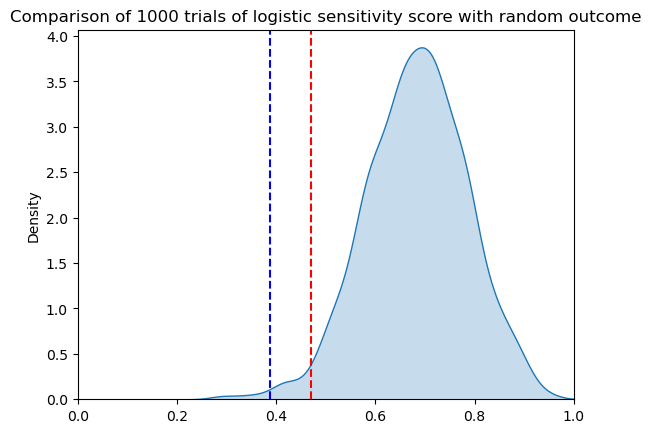

Mean and SD of Sensitivity scores:   0.683 +/- 0.102
Probability that the distribution is below class x = 0.39 is  0.002
Probability that the distribution is below rule 41 x = 0.47 is  0.0182


In [728]:
# Create a smooth distribution plot
sns.kdeplot(values, fill=True)
plt.axvline(x=0.388, color='b', linestyle='--')  # Add a vertical line at x = 0.5
plt.axvline(x=0.47, color='r', linestyle='--')  # Add a vertical line at x = 0.5
plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
plt.title("Comparison of 1000 trials of logistic sensitivity score with random outcome")
plt.show()

print("Mean and SD of Sensitivity scores:  ", round(mean,3),"+/-", round(std_dev,3))
prob_below_class =  norm.cdf(0.39, loc=mean, scale=std_dev)
prob_below_41 =  norm.cdf(0.47, loc=mean, scale=std_dev)
print("Probability that the distribution is below class x = 0.39 is ", 
      round(prob_below_class,4))
print("Probability that the distribution is below rule 41 x = 0.47 is ", 
      round(prob_below_41,4))

# F Using Lasso to reduce features

### Lasso is an attritional regression that takes out non-performing coefficients. Tis was used to reduce the length  of the features list to remove interdependence

In [331]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np

# Assuming X and y are your feature and target variables
lasso = Lasso()
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001])  # Example values for alpha

# Create a parameter grid to search for the best alpha
param_grid = dict(alpha=alphas)

# Perform Grid Search to find the best alpha
grid = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid.best_params_['alpha']

# Train the Lasso model with the best alpha
model = Lasso(alpha=best_alpha)
model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [336]:
# to get it to converge, add more iterations - here 10,000
lasso = Lasso(alpha=0.01, max_iter=10000)  # Example alpha and max_iter values
lasso.fit(X_train, y_train)
feature_rankings = pd.Series(lasso.coef_, index=X_train.columns)
top_features = feature_rankings[feature_rankings != 0].sort_values(ascending=False)
print("Top Features:")
print(top_features)
#lasso.fit(X_train, y_train)
#predictions = lasso.predict(X_test)

Top Features:
sector        0.316850
int_fin       0.206050
ret_voters    0.163480
bus_model    -0.011233
multi_list   -0.017316
blocksh      -0.060461
family       -0.289507
dtype: float64
